Energy Consumption (J): {'RMS': 1755, 'EDF': 1755, 'Hybrid': 2310}
Deadline Miss Rate: {'RMS': 31, 'EDF': 31, 'Hybrid': 33}
System Longevity (s): {'RMS': 11.396011396011396, 'EDF': 11.396011396011396, 'Hybrid': 8.658008658008658}
Task Preemptions: {'RMS': 53, 'EDF': 53, 'Hybrid': 56}
CPU Utilization: {'RMS': 1.2, 'EDF': 1.2, 'Hybrid': 1.2}
Efficiency (Tasks/J): {'RMS': 0.003418803418803419, 'EDF': 0.003418803418803419, 'Hybrid': 0.0025974025974025974}
Throughput (Tasks Completed): {'RMS': 7, 'EDF': 7, 'Hybrid': 6}
Average Latency (s): {'RMS': 12.714285714285714, 'EDF': 12.714285714285714, 'Hybrid': 14.0}


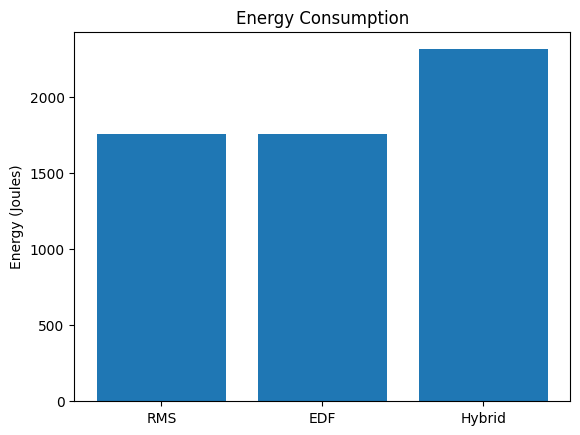

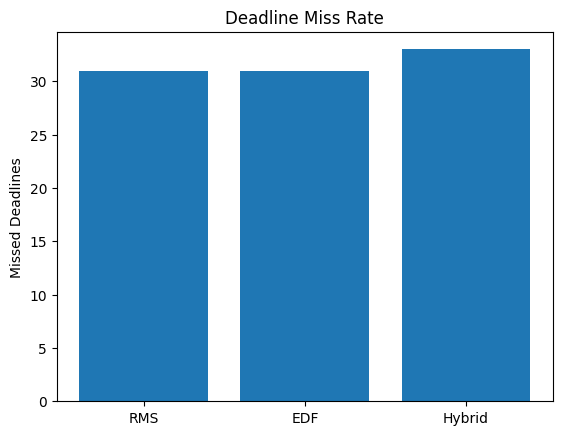

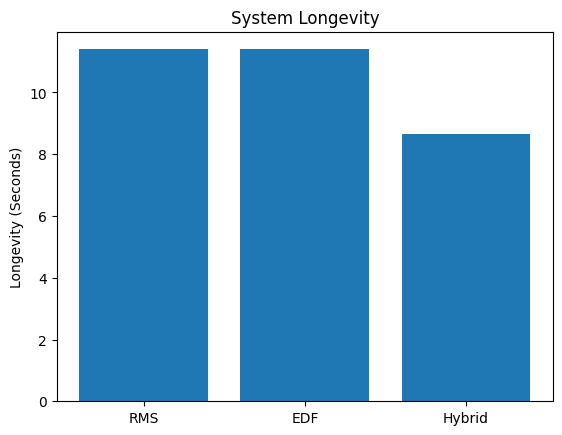

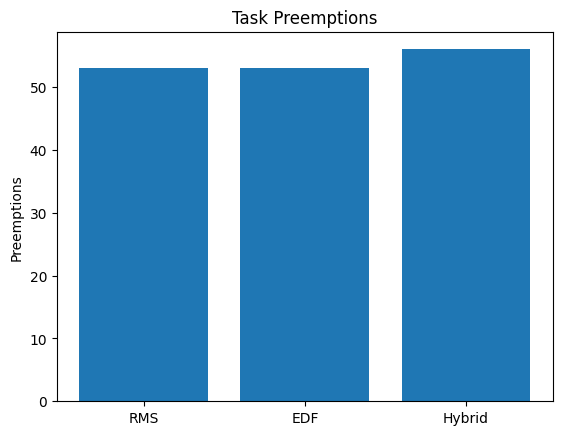

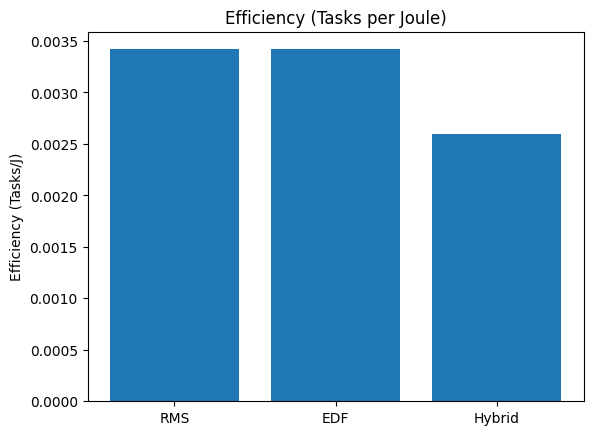

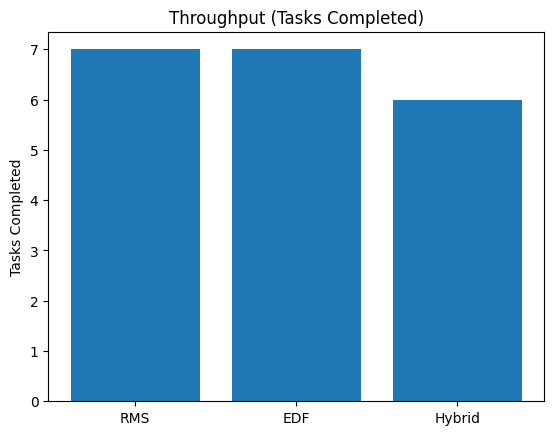

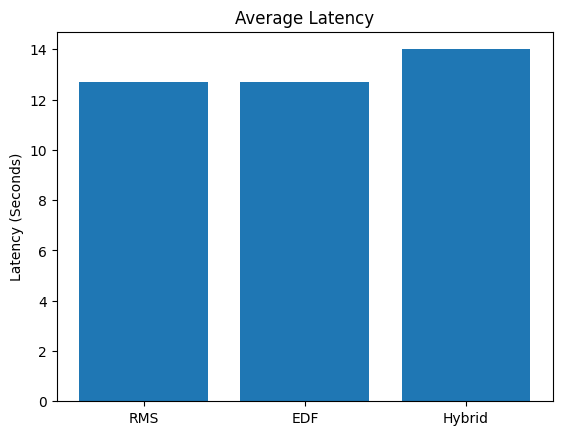

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize

# Task structure: [Task ID, Period, Execution Time, Deadline, Priority (Dynamic)]
tasks = [
    [1, 10, 2, 10, 1],  # Task 1
    [2, 20, 4, 20, 2],  # Task 2
    [3, 15, 3, 15, 3],  # Task 3
    [4, 30, 6, 30, 4],  # Task 4
    [5, 25, 5, 25, 5],  # Task 5
    [6, 40, 8, 40, 6],  # Task 6
]

# Simulation parameters
simulation_time = 200  # Total simulation time in seconds
cpu_freqs = [0.5, 1.0, 1.5]  # CPU frequency states (GHz)
freq_power = {0.5: 5, 1.0: 10, 1.5: 15}  # Power consumption per frequency state (Watts)
battery_capacity = 20000  # Battery capacity in Joules

# Initialize metrics
energy_consumption = {"RMS": 0, "EDF": 0, "Hybrid": 0}
deadline_miss_rate = {"RMS": 0, "EDF": 0, "Hybrid": 0}
system_longevity = {"RMS": 0, "EDF": 0, "Hybrid": 0}
task_preemptions = {"RMS": 0, "EDF": 0, "Hybrid": 0}
utilization = {"RMS": 0, "EDF": 0, "Hybrid": 0}
efficiency = {"RMS": 0, "EDF": 0, "Hybrid": 0}
throughput = {"RMS": 0, "EDF": 0, "Hybrid": 0}
average_latency = {"RMS": 0, "EDF": 0, "Hybrid": 0}
idle_energy = {"RMS": 0, "EDF": 0, "Hybrid": 0}

# Helper function to calculate utilization
def calculate_utilization(tasks):
    return sum(task[2] / task[1] for task in tasks)

# Helper function to calculate efficiency (tasks per joule)
def calculate_efficiency(tasks, energy):
    return len(tasks) / energy if energy > 0 else 0

# Helper function to calculate average latency
def calculate_latency(latencies):
    return sum(latencies) / len(latencies) if latencies else 0

# RMS Scheduling Algorithm
def rms_scheduler(tasks, simulation_time):
    tasks = sorted(tasks, key=lambda x: x[1])  # Sort by period (priority)
    task_queue = []
    current_time = 0
    energy = 0
    missed_deadlines = 0
    preemptions = 0
    completed_tasks = 0
    latencies = []

    while current_time < simulation_time:
        for task in tasks:
            if current_time % task[1] == 0:  # Task arrives
                task_queue.append([task[0], task[2], task[3], current_time])  # Add arrival time

        if task_queue:
            task_queue.sort(key=lambda x: tasks[x[0] - 1][1])  # Sort by priority
            current_task = task_queue.pop(0)
            preemptions += len(task_queue)  # Count preemptions
            freq = 1.0  # Fixed frequency for RMS
            energy += freq_power[freq] * current_task[1]
            current_time += current_task[1]

            # Check deadline
            if current_time > tasks[current_task[0] - 1][3]:
                missed_deadlines += 1
            else:
                completed_tasks += 1
                latencies.append(current_time - current_task[3])
        else:
            energy += freq_power[0.5]  # Idle power
            current_time += 1

    return energy, missed_deadlines, preemptions, completed_tasks, calculate_latency(latencies)

# EDF Scheduling Algorithm
def edf_scheduler(tasks, simulation_time):
    tasks = sorted(tasks, key=lambda x: x[3])  # Sort by deadline
    task_queue = []
    current_time = 0
    energy = 0
    missed_deadlines = 0
    preemptions = 0
    completed_tasks = 0
    latencies = []

    while current_time < simulation_time:
        for task in tasks:
            if current_time % task[1] == 0:  # Task arrives
                task_queue.append([task[0], task[2], task[3], current_time])  # Add arrival time

        if task_queue:
            task_queue.sort(key=lambda x: tasks[x[0] - 1][3])  # Sort by deadline
            current_task = task_queue.pop(0)
            preemptions += len(task_queue)  # Count preemptions
            freq = 1.0  # Fixed frequency for EDF
            energy += freq_power[freq] * current_task[1]
            current_time += current_task[1]

            # Check deadline
            if current_time > tasks[current_task[0] - 1][3]:
                missed_deadlines += 1
            else:
                completed_tasks += 1
                latencies.append(current_time - current_task[3])
        else:
            energy += freq_power[0.5]  # Idle power
            current_time += 1

    return energy, missed_deadlines, preemptions, completed_tasks, calculate_latency(latencies)

# Hybrid Scheduling Algorithm
def hybrid_scheduler(tasks, simulation_time):
    task_queue = []
    current_time = 0
    energy = 0
    missed_deadlines = 0
    preemptions = 0
    completed_tasks = 0
    latencies = []

    while current_time < simulation_time:
        for task in tasks:
            if current_time % task[1] == 0:  # Task arrives
                task_queue.append([task[0], task[2], task[3], current_time])  # Add arrival time

        if task_queue:
            task_queue.sort(key=lambda x: (tasks[x[0] - 1][1], tasks[x[0] - 1][3]))  # Prioritize by RMS and secondary by EDF
            current_task = task_queue.pop(0)
            preemptions += len(task_queue)  # Count preemptions

            # Enhanced AI-optimized frequency adjustment
            slack_time = tasks[current_task[0] - 1][3] - (current_time + current_task[1])
            if slack_time < 5:
                freq = 1.5
            elif slack_time < 10 and len(task_queue) > 2:
                freq = 1.0  # Intermediate frequency for balanced tasks
            else:
                freq = 0.5  # Lowest frequency for energy efficiency

            energy += freq_power[freq] * current_task[1]
            current_time += current_task[1]

            # Check deadline
            if current_time > tasks[current_task[0] - 1][3]:
                missed_deadlines += 1
            else:
                completed_tasks += 1
                latencies.append(current_time - current_task[3])
        else:
            energy += freq_power[0.5]  # Idle power
            current_time += 1

    return energy, missed_deadlines, preemptions, completed_tasks, calculate_latency(latencies)

# Run simulations
energy_consumption["RMS"], deadline_miss_rate["RMS"], task_preemptions["RMS"], throughput["RMS"], average_latency["RMS"] = rms_scheduler(tasks, simulation_time)
energy_consumption["EDF"], deadline_miss_rate["EDF"], task_preemptions["EDF"], throughput["EDF"], average_latency["EDF"] = edf_scheduler(tasks, simulation_time)
energy_consumption["Hybrid"], deadline_miss_rate["Hybrid"], task_preemptions["Hybrid"], throughput["Hybrid"], average_latency["Hybrid"] = hybrid_scheduler(tasks, simulation_time)

# System longevity calculation
for key in energy_consumption:
    system_longevity[key] = battery_capacity / energy_consumption[key]

# Utilization calculation
utilization["RMS"] = calculate_utilization(tasks)
utilization["EDF"] = calculate_utilization(tasks)
utilization["Hybrid"] = calculate_utilization(tasks)

# Efficiency calculation
efficiency["RMS"] = calculate_efficiency(tasks, energy_consumption["RMS"])
efficiency["EDF"] = calculate_efficiency(tasks, energy_consumption["EDF"])
efficiency["Hybrid"] = calculate_efficiency(tasks, energy_consumption["Hybrid"])

# Results
print("Energy Consumption (J):", energy_consumption)
print("Deadline Miss Rate:", deadline_miss_rate)
print("System Longevity (s):", system_longevity)
print("Task Preemptions:", task_preemptions)
print("CPU Utilization:", utilization)
print("Efficiency (Tasks/J):", efficiency)
print("Throughput (Tasks Completed):", throughput)
print("Average Latency (s):", average_latency)

# Visualization
algorithms = ["RMS", "EDF", "Hybrid"]

# Energy Consumption
plt.bar(algorithms, [energy_consumption[alg] for alg in algorithms])
plt.title("Energy Consumption")
plt.ylabel("Energy (Joules)")
plt.show()

# Deadline Miss Rate
plt.bar(algorithms, [deadline_miss_rate[alg] for alg in algorithms])
plt.title("Deadline Miss Rate")
plt.ylabel("Missed Deadlines")
plt.show()

# System Longevity
plt.bar(algorithms, [system_longevity[alg] for alg in algorithms])
plt.title("System Longevity")
plt.ylabel("Longevity (Seconds)")
plt.show()

# Task Preemptions
plt.bar(algorithms, [task_preemptions[alg] for alg in algorithms])
plt.title("Task Preemptions")
plt.ylabel("Preemptions")
plt.show()

# Efficiency
plt.bar(algorithms, [efficiency[alg] for alg in algorithms])
plt.title("Efficiency (Tasks per Joule)")
plt.ylabel("Efficiency (Tasks/J)")
plt.show()

# Throughput
plt.bar(algorithms, [throughput[alg] for alg in algorithms])
plt.title("Throughput (Tasks Completed)")
plt.ylabel("Tasks Completed")
plt.show()

# Average Latency
plt.bar(algorithms, [average_latency[alg] for alg in algorithms])
plt.title("Average Latency")
plt.ylabel("Latency (Seconds)")
plt.show()
